# Stable Diffusion -> SVG -> Scoring Metric + Simple SVG

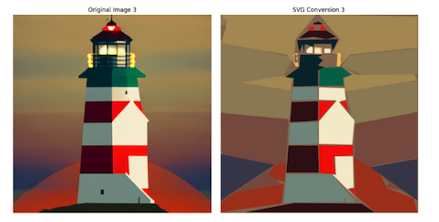

0. Using init svg as the svg in kawchar85/lb-0-508-simple-svg
1. Use Stable Diffusion to generate images for prompts
2. Convert images to svg
3. Use competition metric to grade
4. Repeat steps 1-3 X times - and choose best scoring image

Depending on configuration - the notebook takes about ~10-20 seconds to generate, convert and score a single image.

At 20 inference steps for Stable Diffusion - this allows for 3-4x image candidates per prompt given time constraints.

**Now featuring LB score and runtime estimation!**

In [1]:
#| default_exp core

In [2]:
#| export

import kagglehub

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

from diffusers import StableDiffusionPipeline
from transformers import AutoProcessor, AutoModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Competition Metric
* https://www.kaggle.com/code/metric/svg-image-fidelity
* Umodified except for model paths in AestheticEvaluator (for kagglehub packaging)

In [3]:
#| export

import io
from math import prod
from statistics import mean

from IPython.display import SVG

import cairosvg
import clip
import kagglehub
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    PaliGemmaForConditionalGeneration,
)

svg_constraints = kagglehub.package_import('metric/svg-constraints')

class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str
) -> float:
    """Calculates a fidelity score by comparing generated SVG images to target text descriptions.

    Parameters
    ----------
    solution : pd.DataFrame
        A DataFrame containing target text descriptions. Must have a column named 'description'.
    submission : pd.DataFrame
        A DataFrame containing generated SVG strings. Must have a column named 'svg'.
    row_id_column_name : str
        The name of the column containing row identifiers. This column is removed before scoring.

    Returns
    -------
    float
        The mean fidelity score (a value between 0 and 1) representing the average similarity between the generated SVGs and their descriptions.
        A higher score indicates better fidelity.

    Raises
    ------
    ParticipantVisibleError
        If the 'svg' column in the submission DataFrame is not of string type or if validation of the SVG fails.

    Examples
    --------
    >>> import pandas as pd
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'description': ['red ball', 'swimming pool']
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'svg': ['<svg viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red"/></svg>',
    ...         '<svg viewBox="0 0 100 100"><rect x="10" y="10" width="80" height="80" fill="blue"/></svg>']
    ... })
    >>> score(solution, submission, 'id')
    0...
    """
    # Validate
    del solution[row_id_column_name], submission[row_id_column_name]
    if not pd.api.types.is_string_dtype(submission.loc[:, 'svg']):
        raise ParticipantVisibleError('svg must be a string.')
    # check that SVG code meets defined constraints
    constraints = svg_constraints.SVGConstraints()
    try:
        for svg in submission.loc[:, 'svg']:
            constraints.validate_svg(svg)
    except:
        raise ParticipantVisibleError('SVG code violates constraints.')

    # Score
    vqa_evaluator = VQAEvaluator()
    aesthetic_evaluator = AestheticEvaluator()

    results = []
    try:
        for svg, description in zip(
            submission.loc[:, 'svg'], solution.loc[:, 'description'], strict=True
        ):
            image = svg_to_png(svg)
            vqa_score = vqa_evaluator.score(image, 'SVG illustration of ' + description)
            aesthetic_score = aesthetic_evaluator.score(image)
            instance_score = harmonic_mean(vqa_score, aesthetic_score, beta=2.0)
            results.append(instance_score)

    except:
        raise ParticipantVisibleError('SVG failed to score.')

    fidelity = mean(results)
    return float(fidelity)


class VQAEvaluator:
    """Evaluates images based on their similarity to a given text description."""

    def __init__(self):
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.model_path = kagglehub.model_download(
            'google/paligemma-2/transformers/paligemma2-10b-mix-448'
        )
        self.processor = AutoProcessor.from_pretrained(self.model_path)
        self.model = PaliGemmaForConditionalGeneration.from_pretrained(
            self.model_path,
            low_cpu_mem_usage=True,
            quantization_config=self.quantization_config,
        )
        self.questions = {
            'fidelity': 'Does <image> portray "{}" without any lettering? Answer yes or no.',
            'text': '<image> Text present: yes or no?',
        }

    def score(self, image: Image.Image, description: str) -> float:
        """Evaluates the fidelity of an image to a target description using VQA yes/no probabilities.

        Parameters
        ----------
        image : PIL.Image.Image
            The image to evaluate.
        description : str
            The text description that the image should represent.

        Returns
        -------
        float
            The score (a value between 0 and 1) representing the match between the image and its description.
        """
        p_fidelity = self.get_yes_probability(image, self.questions['fidelity'].format(description))
        p_text = self.get_yes_probability(image, self.questions['text'])
        return p_fidelity * (1 - p_text)

    def mask_yes_no(self, logits):
        """Masks logits for 'yes' or 'no'."""
        yes_token_id = self.processor.tokenizer.convert_tokens_to_ids('yes')
        no_token_id = self.processor.tokenizer.convert_tokens_to_ids('no')
        yes_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' yes')
        no_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' no')

        mask = torch.full_like(logits, float('-inf'))
        mask[:, yes_token_id] = logits[:, yes_token_id]
        mask[:, no_token_id] = logits[:, no_token_id]
        mask[:, yes_with_space_token_id] = logits[:, yes_with_space_token_id]
        mask[:, no_with_space_token_id] = logits[:, no_with_space_token_id]
        return mask

    def get_yes_probability(self, image, prompt) -> float:
        inputs = self.processor(images=image, text=prompt, return_tensors='pt').to(
            'cuda:0'
        )

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Logits for the last (predicted) token
            masked_logits = self.mask_yes_no(logits)
            probabilities = torch.softmax(masked_logits, dim=-1)

        yes_token_id = self.processor.tokenizer.convert_tokens_to_ids('yes')
        no_token_id = self.processor.tokenizer.convert_tokens_to_ids('no')
        yes_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' yes')
        no_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' no')

        prob_yes = probabilities[0, yes_token_id].item()
        prob_no = probabilities[0, no_token_id].item()
        prob_yes_space = probabilities[0, yes_with_space_token_id].item()
        prob_no_space = probabilities[0, no_with_space_token_id].item()

        total_yes_prob = prob_yes + prob_yes_space
        total_no_prob = prob_no + prob_no_space

        total_prob = total_yes_prob + total_no_prob
        renormalized_yes_prob = total_yes_prob / total_prob

        return renormalized_yes_prob


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)

class AestheticEvaluator:
    def __init__(self):

# -----------------modified paths for packaging!!!!-----------------
        self.model_path = kagglehub.notebook_output_download(
            'metric/sac-logos-ava1-l14-linearmse'
        ) + '/sac+logos+ava1-l14-linearMSE.pth'

        self.clip_model_path = kagglehub.notebook_output_download(
            'metric/openai-clip-vit-large-patch14'
        ) + '/ViT-L-14.pt'

        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(self.model_path, weights_only=True, map_location='cuda:1')

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to('cuda:1')
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device='cuda:1')

        return predictor, clip_model, preprocessor


    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to('cuda:1')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to('cuda:1').float())

        return score.item() / 10.0  # scale to [0, 1]


def harmonic_mean(a: float, b: float, beta: float = 1.0) -> float:
    """
    Calculate the harmonic mean of two values, weighted using a beta parameter.

    Args:
        a: First value (e.g., precision)
        b: Second value (e.g., recall)
        beta: Weighting parameter

    Returns:
        Weighted harmonic mean
    """
    # Handle zero values to prevent division by zero
    if a <= 0 or b <= 0:
        return 0.0
    return (1 + beta**2) * (a * b) / (beta**2 * a + b)


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)

# Load Stable Diffusion

In [4]:
#| export

# Ensure GPU is being used and optimize for speed
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler


# Load with optimized scheduler and half precision
stable_diffusion_path = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")

scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    stable_diffusion_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,  # Use half precision
    safety_checker=None         # Disable safety checker for speed
)

# Move to GPU and apply optimizations
pipe.to(device)

Using device: cuda:1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "/kaggle/input/stable-diffusion-v2/pytorch/1/1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Competition Metric Helpers

In [5]:
#| export

global_vqa_evaluator = None
global_aesthetic_evaluator = None

def initialize_evaluators():
    """Initialize the evaluators once and store them in global variables"""
    global global_vqa_evaluator, global_aesthetic_evaluator
    
    if global_vqa_evaluator is None:
        print("Initializing VQA Evaluator...")
        global_vqa_evaluator = VQAEvaluator()
    
    if global_aesthetic_evaluator is None:
        print("Initializing Aesthetic Evaluator...")
        global_aesthetic_evaluator = AestheticEvaluator()
    
    return global_vqa_evaluator, global_aesthetic_evaluator


def evaluate_with_competition_metric(svg, prompt):

    vqa_evaluator, aesthetic_evaluator = initialize_evaluators()

    image = svg_to_png(svg)
    # Calculate scores
    vqa_score = vqa_evaluator.score(image, 'SVG illustration of ' + prompt)
    aesthetic_score = aesthetic_evaluator.score(image)
    combined_score = harmonic_mean(vqa_score, aesthetic_score, beta=2.0)
    
    return {
        'vqa_score': vqa_score,
        'aesthetic_score': aesthetic_score,
        'combined_score': combined_score
    }

# Image -> SVG
* Did a bunch of work here trying to get good results..

In [6]:
#| export

def compress_hex_color(hex_color):
    """Convert hex color to shortest possible representation"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

def extract_features_by_scale(img_np, num_colors=12):
    """
    Extract image features hierarchically by scale
    
    Args:
        img_np (np.ndarray): Input image
        num_colors (int): Number of colors to quantize
    
    Returns:
        list: Hierarchical features sorted by importance
    """
    # Convert to RGB if needed
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # Perform color quantization
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Quantized image
    palette = centers.astype(np.uint8)
    quantized = palette[labels.flatten()].reshape(img_rgb.shape)
    
    # Hierarchical feature extraction
    hierarchical_features = []
    
    # Sort colors by frequency
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_colors = [palette[i] for i in sorted_indices]
    
    # Center point for importance calculations
    center_x, center_y = width/2, height/2
    
    for color in sorted_colors:
        # Create color mask
        color_mask = cv2.inRange(quantized, color, color)
        
        # Find contours
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Convert RGB to compressed hex
        hex_color = compress_hex_color(f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}')
        
        color_features = []
        for contour in contours:
            # Skip tiny contours
            area = cv2.contourArea(contour)
            if area < 20:
                continue
            
            # Calculate contour center
            m = cv2.moments(contour)
            if m["m00"] == 0:
                continue
            
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])
            
            # Distance from image center (normalized)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)
            
            # Simplify contour
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Generate points string
            points = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx])
            
            # Calculate importance (area, proximity to center, complexity)
            importance = (
                area * 
                (1 - dist_from_center) * 
                (1 / (len(approx) + 1))
            )
            
            color_features.append({
                'points': points,
                'color': hex_color,
                'area': area,
                'importance': importance
            })
        
        # Sort features by importance within this color
        color_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_features)
    
    # Final sorting by overall importance
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
    
    return hierarchical_features

def bitmap_to_svg_layered(image, max_size_bytes=10000, resize=True, target_size=(256, 256)):
    """
    Convert bitmap to SVG using layered feature extraction
    
    Args:
        image: Input image (PIL.Image)
        max_size_bytes (int): Maximum SVG size
        resize (bool): Whether to resize the image before processing
        target_size (tuple): Target size for resizing (width, height)
    
    Returns:
        str: SVG representation
    """
    # Resize the image if requested
    if resize:
        original_size = image.size
        image = image.resize(target_size, Image.LANCZOS)
    else:
        original_size = image.size
    
    # Convert to numpy array
    img_np = np.array(image)
    
    # Get image dimensions
    height, width = img_np.shape[:2]
    
    # Calculate average background color
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        avg_bg_color = np.mean(img_np, axis=(0,1)).astype(int)
        bg_hex_color = compress_hex_color(f'#{avg_bg_color[0]:02x}{avg_bg_color[1]:02x}{avg_bg_color[2]:02x}')
    else:
        bg_hex_color = '#fff'
    
    # Start building SVG
    # Use original dimensions in viewBox for proper scaling when displayed
    orig_width, orig_height = original_size
    svg = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}">\n'
    svg += f'<rect width="{width}" height="{height}" fill="{bg_hex_color}"/>\n'
    
    # Extract hierarchical features
    features = extract_features_by_scale(img_np)
    
    # Add features layer by layer
    for feature in features:
        # Try adding the feature
        temp_svg = svg + f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n</svg>'
        
        # Check if adding this feature exceeds size limit
        if len(temp_svg.encode('utf-8')) > max_size_bytes:
            break
        
        # Add the feature
        svg += f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
    
    # Close SVG
    svg += '</svg>'
    
    # Final size check
    if len(svg.encode('utf-8')) > max_size_bytes:
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width} {height}"><rect width="{width}" height="{height}" fill="{bg_hex_color}"/></svg>'
    
    return svg

# Bitmap Generation
* Inference steps (more for better quality / slower)
* Guidance scale (how tightly to follow prompts)

In [7]:
#| export

def generate_bitmap(prompt, negative_prompt="", num_inference_steps=20, guidance_scale=15):
        
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps, 
        guidance_scale=guidance_scale
    ).images[0]
    
    return image

#  Generate Image, Convert to SVG, and Score
* Repeat as needed - pick the best scoring SVG

In [8]:
# | export
DEFAULT_SVG = """
<svg width="1000" height="1000" viewBox="0 0 1000 1000" xmlns="http://www.w3.org/2000/svg">
  <defs>
    <radialGradient id="bg" cx="60%" cy="40%" r="85%">
      <stop offset="0%" stop-color="#0f172a"/>
      <stop offset="100%" stop-color="#1e3b8a"/>
    </radialGradient>

    <linearGradient id="neon" x1="0" y1="0" x2="1" y2="1">
      <stop offset="0%" stop-color="#4ade80"/>
      <stop offset="50%" stop-color="#2dd4bf"/>
      <stop offset="100%" stop-color="#5eead4"/>
    </linearGradient>

    <pattern id="grid" width="100" height="100" patternUnits="userSpaceOnUse">
      <path d="M100 0H0v100" stroke="#f8fafc" stroke-width="2" opacity="0.1"/>
    </pattern>
  </defs>

  <rect width="1000" height="1000" fill="url(#bg)"/>
  <rect width="1000" height="1000" fill="url(#grid)" opacity="0.15"/>

  <g transform="translate(500 500)">
    <path d="M0-200L57-193 193-57 200 0 193 57 57 193 0 200-57 193-193 57-200 0-193-57-57-193Z" 
          fill="none"
          stroke="url(#neon)"
          stroke-width="15"
          stroke-linejoin="round"
          opacity="0.97"/>

    <g transform="scale(0.6)">
      <circle r="140" fill="#4ade80" opacity="0.95"/>
      <path d="M-100-100L100 100M100-100L-100 100" 
            stroke="#0f172a" 
            stroke-width="25"
            stroke-linecap="round"/>
      <g stroke="#2dd4bf" stroke-width="8">
        <path d="M0-140L0-200M0 140L0 200"/>
        <path d="M-140 0L-200 0M140 0L200 0"/>
      </g>
    </g>

    <circle cx="300" cy="0" r="15" fill="#5eead4"/>
    <circle cx="-300" cy="0" r="15" fill="#5eead4"/>
  </g>

  <g opacity="0.3">
    <circle cx="250" cy="250" r="30" fill="url(#neon)"/>
    <circle cx="750" cy="750" r="40" fill="#2dd4bf"/>
    <rect x="600" y="200" width="60" height="60" rx="15" fill="#5eead4"/>
    <path d="M200 600L300 700 400 600Z" fill="#4ade80"/>
  </g>

  <g stroke="#f8fafc" stroke-width="4" opacity="0.15">
    <path d="M500 100L500 900"/>
    <path d="M100 500L900 500"/>
  </g>
</svg>"""

In [9]:
# | export
def generate_and_convert(
    prompt,
    negative_prompt="",
    num_attempts=3,
    num_inference_steps=20,
    guidance_scale=15,
    verbose=True,
):
    """
    Generate image with Stable Diffusion, convert to SVG, and evaluate using competition metric
    with side-by-side comparison of original and SVG-converted images
    """
    best_svg = None
    best_similarity = -1


    generation_time = 0
    conversion_time = 0
    # Track total processing time
    total_start_time = time.time()

    # Track timing statistics
    generation_times = []
    conversion_times = []
    evaluation_times = []
    attempt_times = []
    
    for i in range(num_attempts):
        attempt_start_time = time.time()
        if verbose:
            print(f"\n=== Attempt {i+1}/{num_attempts} ===")

        if i == 0:
            svg_content = DEFAULT_SVG
        else:
        # Generate bitmap with Stable Diffusion
            generation_start = time.time()
            bitmap = generate_bitmap(
                prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            )
            generation_end = time.time()
            generation_time = generation_end - generation_start
            generation_times.append(generation_time)

            # Convert to SVG with size limit
            if verbose:
                print(f"Converting to SVG... ", end="")
            conversion_start = time.time()
            svg_content = bitmap_to_svg_layered(bitmap)
            conversion_end = time.time()
            conversion_time = conversion_end - conversion_start
            conversion_times.append(conversion_time)

        # Render SVG to bitmap for evaluation
        rendered_svg = svg_to_png(svg_content)
        svg_size = len(svg_content.encode("utf-8"))
        if verbose:
            print(f"SVG size: {svg_size} bytes")

        if verbose and i != 0:
            # Display the images side by side
            plt.figure(figsize=(12, 6))

            # Original bitmap
            plt.subplot(1, 2, 1)
            plt.imshow(bitmap)
            plt.title(f"Original Image {i+1}")
            plt.axis("off")

            # SVG conversion
            plt.subplot(1, 2, 2)
            plt.imshow(rendered_svg)
            plt.title(f"SVG Conversion {i+1}")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        # Evaluate rendered SVG with competition metric
        evaluation_start = time.time()
        svg_scores = evaluate_with_competition_metric(svg_content, prompt)
        evaluation_end = time.time()
        evaluation_time = evaluation_end - evaluation_start
        evaluation_times.append(evaluation_time)

        if verbose:
            print(f"SVG VQA Score: {svg_scores['vqa_score']:.4f}")
            print(f"SVG Aesthetic Score: {svg_scores['aesthetic_score']:.4f}")
            print(f"SVG Competition Score: {svg_scores['combined_score']:.4f}")

        # Track the best result using competition score
        if svg_scores["combined_score"] > best_similarity:
            best_similarity = svg_scores["combined_score"]
            best_svg = svg_content
            if verbose:
                print(f"✅ New best result: {svg_scores['combined_score']:.4f}")
        else:
            if verbose:
                print(f"❌ Not better than current best: {best_similarity:.4f}")

        # Calculate total time for this attempt
        attempt_end_time = time.time()
        attempt_time = attempt_end_time - attempt_start_time
        attempt_times.append(attempt_time)

        if verbose:
            print(f"Image generation time: {generation_time:.2f}s")
            print(f"SVG conversion time: {conversion_time:.2f}s")
            print(f"Image evaluation time: {evaluation_time:.2f}s")
            print(f"Total time for attempt {i+1}: {attempt_time:.2f}s")

    # Calculate total processing time
    total_end_time = time.time()
    total_time = total_end_time - total_start_time

    # Print timing summary if verbose
    if verbose:
        print("\n=== Timing Summary ===")
        print(
            f"Average image generation time: {sum(generation_times)/len(generation_times):.2f}s"
        )
        print(
            f"Average SVG conversion time: {sum(conversion_times)/len(conversion_times):.2f}s"
        )
        print(
            f"Average image evaluation time: {sum(evaluation_times)/len(evaluation_times):.2f}s"
        )
        print(f"Average time per attempt: {sum(attempt_times)/len(attempt_times):.2f}s")
        print(f"Total processing time ({num_attempts} attempts): {total_time:.2f}s")
        print(f"Best score achieved: {best_similarity:.4f}")

    return best_svg, best_similarity


# Try it out!


=== Attempt 1/5 ===
SVG size: 1994 bytes
Initializing VQA Evaluator...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Initializing Aesthetic Evaluator...


The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


SVG VQA Score: 0.4602
SVG Aesthetic Score: 0.5982
SVG Competition Score: 0.5643
✅ New best result: 0.5643
Image generation time: 0.00s
SVG conversion time: 0.00s
Image evaluation time: 121.53s
Total time for attempt 1: 121.73s

=== Attempt 2/5 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Converting to SVG... SVG size: 3725 bytes


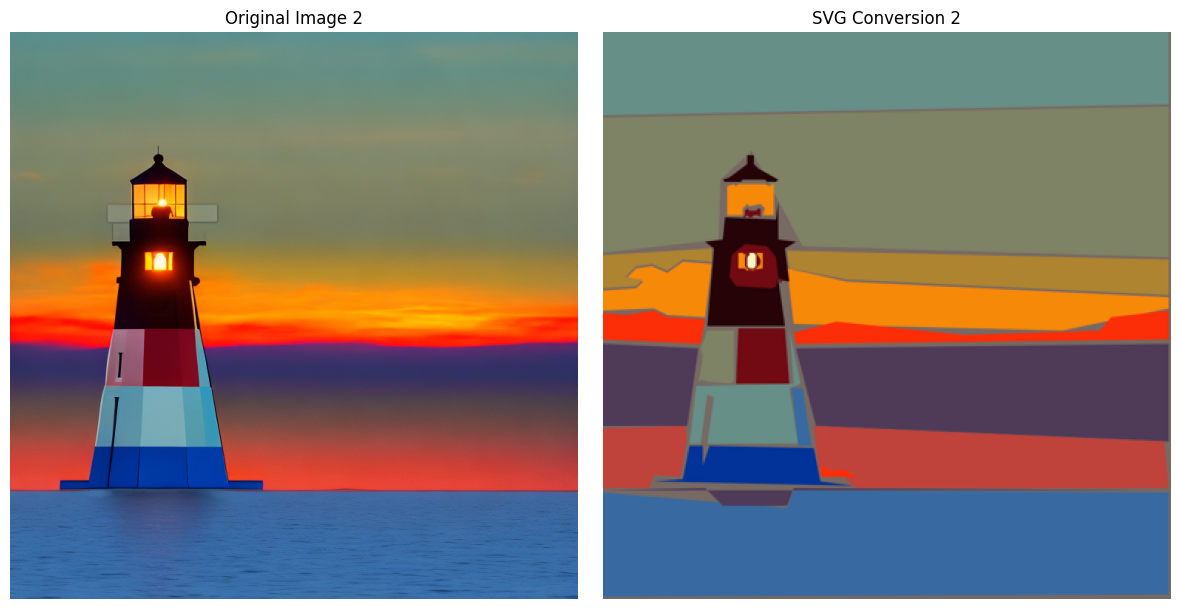

SVG VQA Score: 0.3807
SVG Aesthetic Score: 0.5152
SVG Competition Score: 0.4812
❌ Not better than current best: 0.5643
Image generation time: 7.35s
SVG conversion time: 1.31s
Image evaluation time: 3.46s
Total time for attempt 2: 12.73s

=== Attempt 3/5 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Converting to SVG... SVG size: 8390 bytes


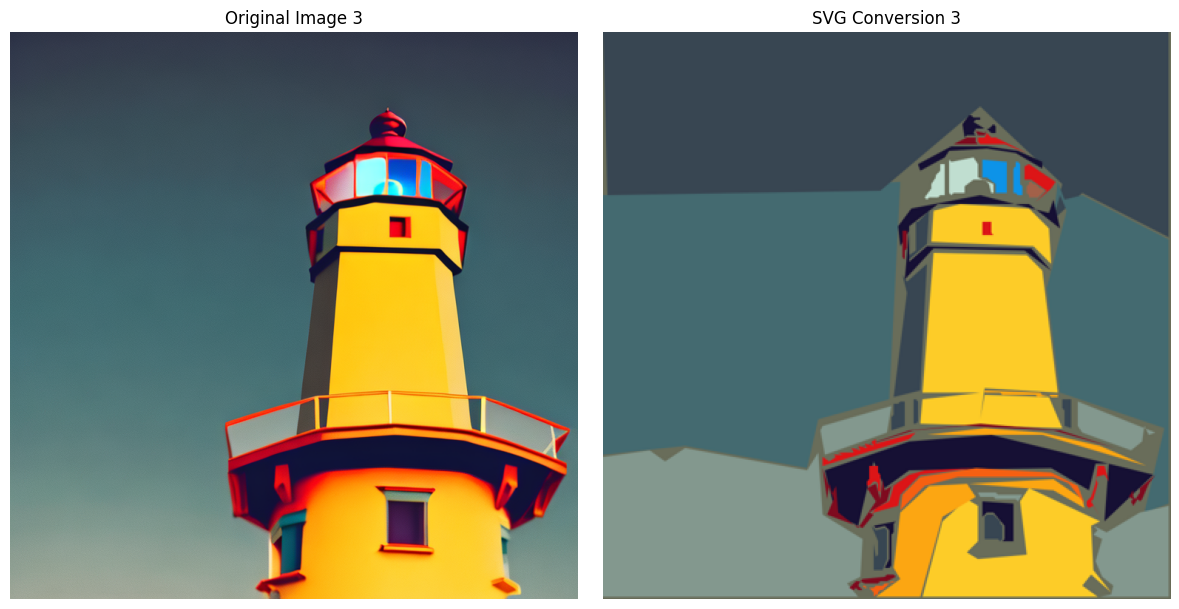

SVG VQA Score: 0.4056
SVG Aesthetic Score: 0.5143
SVG Competition Score: 0.4881
❌ Not better than current best: 0.5643
Image generation time: 7.33s
SVG conversion time: 1.01s
Image evaluation time: 3.47s
Total time for attempt 3: 12.33s

=== Attempt 4/5 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Converting to SVG... SVG size: 6835 bytes


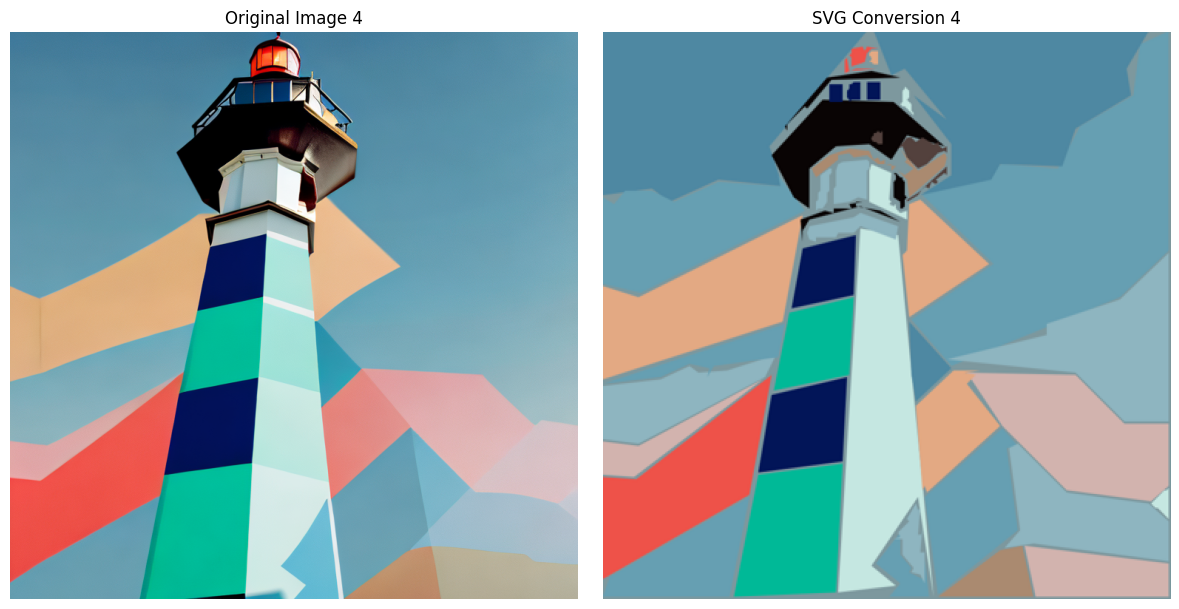

SVG VQA Score: 0.3983
SVG Aesthetic Score: 0.5273
SVG Competition Score: 0.4953
❌ Not better than current best: 0.5643
Image generation time: 7.42s
SVG conversion time: 0.77s
Image evaluation time: 3.50s
Total time for attempt 4: 12.22s

=== Attempt 5/5 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Converting to SVG... SVG size: 1746 bytes


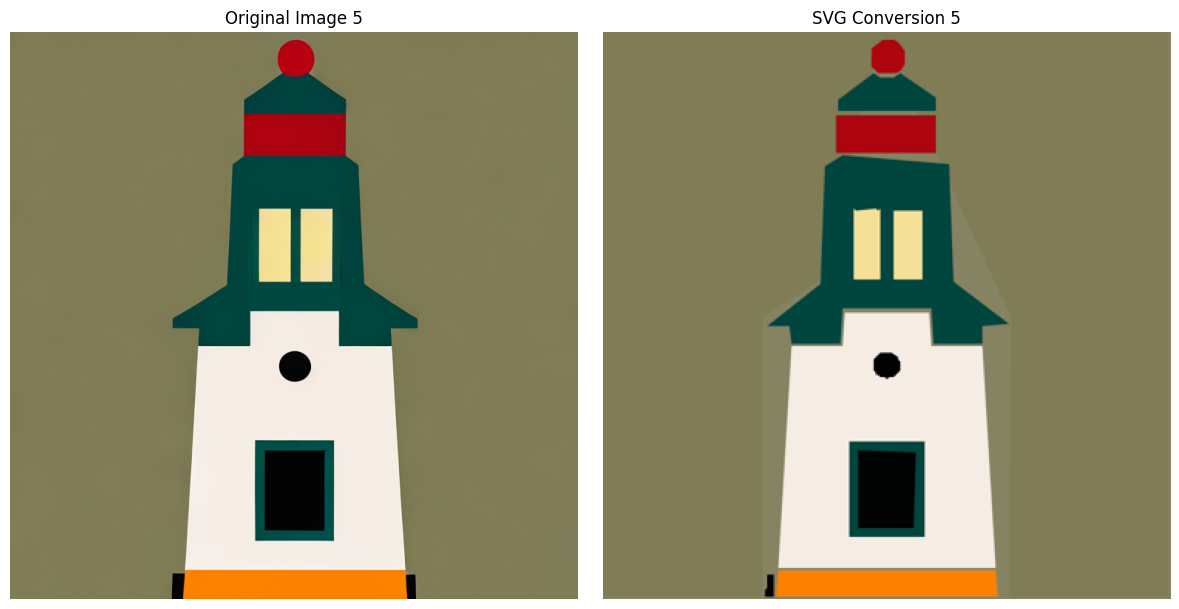

SVG VQA Score: 0.4181
SVG Aesthetic Score: 0.4724
SVG Competition Score: 0.4604
❌ Not better than current best: 0.5643
Image generation time: 7.49s
SVG conversion time: 0.54s
Image evaluation time: 3.49s
Total time for attempt 5: 12.03s

=== Timing Summary ===
Average image generation time: 7.40s
Average SVG conversion time: 0.91s
Average image evaluation time: 27.09s
Average time per attempt: 34.21s
Total processing time (5 attempts): 171.03s
Best score achieved: 0.5643


In [10]:
## Note: These parameters are just for testing - modify parameters in the model definition for submission

prompt = ("Close up of "
          "a lighthouse overlooking the ocean"
          " flat color blocks, beautiful, minimal details, solid colors only")

negative_prompt = "lines, hatching, textures, patterns, details, outlines"

best_svg, best_score = generate_and_convert(prompt, negative_prompt=negative_prompt, num_inference_steps=20, num_attempts=5)

# Our Model Function
## Configure parameters for submission here!

In [11]:
#| export

class Model:
    def __init__(self):
        '''Optional constructor, performs any setup logic, model instantiation, etc.'''
        
        # Set number of image attempts per prompt for competition here...

        self.num_attempts_per_prompt = 6
        self.num_inference_steps = 15
        self.guidance_scale = 15

        self.prompt_prefix = "Close up of"
        self.prompt_suffix = "flat color blocks, beautiful, minimal details, solid colors only"
        self.negative_prompt = "lines, hatching, textures, patterns, details, outlines"

        self.last_score = None
            
        pass
      
    def predict(self, prompt: str) -> str:
        '''Generates SVG which produces an image described by the prompt.

        Args:
            prompt (str): A prompt describing an image
        Returns:
            String of valid SVG code.
        '''

        full_prompt = self.prompt_prefix + " " + prompt + " " + self.prompt_suffix

        best_svg, best_score = generate_and_convert(
            full_prompt,
            negative_prompt=self.negative_prompt,
            num_attempts=self.num_attempts_per_prompt,
            num_inference_steps=self.num_inference_steps,
            guidance_scale=self.guidance_scale,
            verbose=False
        )

        self.last_score = best_score
        
        return best_svg

# Test Model (LB prediction!)
* Try running the model against the train data
* Uses the scoring metric to make an LB prediction
* Note run-time (should give good idea if things are fast enough to submit)

In [12]:
# # Read the CSV file
# df = pd.read_csv('/kaggle/input/drawing-with-llms/train.csv')

# # uncomment to test on just a few
# #df = df.head(3)

# # Initialize the model
# model = Model()

# # Create arrays to store scores and timing data
# scores = []
# generation_times = []

# for i, row in enumerate(df.iterrows()):
#     description = row[1]['description']
    
#     # Start timing
#     start_time = time.time()
    
#     # Generate image from description
#     svg = model.predict(description)
#     rendered_img = svg_to_png(svg)
    
#     # End timing
#     end_time = time.time()
#     generation_time = end_time - start_time
#     generation_times.append(generation_time)
    
#     # Get the score
#     score = model.last_score
#     scores.append(score)
        
#     # Display the image being processed
#     plt.figure(figsize=(10, 8))
#     plt.imshow(rendered_img)
#     plt.title(f"Prompt: {description}\nScore: {score:.2f}")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    
#     # Print progress, current average score, and timing info
#     current_avg_score = np.mean(scores)
#     current_avg_time = np.mean(generation_times)
    
#     print(f"Processed {i+1}/{len(df)} images")
#     print(f"Current average score: {current_avg_score:.2f}")
#     print(f"Time for this image: {generation_time:.2f}s")
#     print(f"Current average generation time: {current_avg_time:.2f}s")
    
# # When all done, calculate final statistics
# avg_score = np.mean(scores)
# avg_generation_time = np.mean(generation_times)
# total_time_taken = sum(generation_times)

# # Calculate projections for 500 images
# projected_time_500_images = 500 * avg_generation_time
# projected_hours = projected_time_500_images / 3600

# print("\n=== SUMMARY ===")
# print(f"Images processed: {len(df)}")
# print(f"Final average score: {avg_score:.2f}")
# print(f"Average generation time per image: {avg_generation_time:.2f} seconds")
# print(f"Total time elapsed: {timedelta(seconds=total_time_taken)}")
# print(f"Projected time for 500 images: {projected_hours:.2f} hours ({timedelta(seconds=projected_time_500_images)})")